<a href="https://colab.research.google.com/github/nitintimble/human_passport/blob/main/passport_NO_passport_classifier_model_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANT : for downloading zip from github to colab, temporary make repo public. Once first step is done, change github repo visibility to private

Same applies for accessing inference images

In [17]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "human_images"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download passport no-passport data
    with open(data_path / "human_passport.zip", "wb") as f:
        request = requests.get("https://github.com/nitintimble/human_passport/raw/main/human_passport.zip")
        print("Downloading passport & no passport images...")
        f.write(request.content)

    # Download passport no-passport data
    with zipfile.ZipFile(data_path / "human_passport.zip", "r") as zip_ref:
        print("Unzipping passport no passport data...")
        zip_ref.extractall(image_path)

Did not find data/human_images directory, creating one...
Unzipping passport no passport data...


In [16]:
# rm -rf data/

In [18]:
import os
import zipfile
from pathlib import Path
import requests
import matplotlib.pyplot as plt
import torch
import torchvision

In [19]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [20]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

## Transfer elarning using - EfficientNet_B0_Weights

In [21]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [22]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [23]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a3aac33ff10>,
 ['nopassport', 'passport'])

In [24]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [25]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 235MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [26]:
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
# model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# Get the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Create the model with pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

## Freezing base model

In [27]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [28]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [33]:
from torch import nn
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [35]:
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [36]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.6564 | train_acc: 0.5580 | test_loss: 0.5825 | test_acc: 0.7292
Epoch: 2 | train_loss: 0.4626 | train_acc: 0.8527 | test_loss: 0.4555 | test_acc: 0.8681
Epoch: 3 | train_loss: 0.3297 | train_acc: 0.9777 | test_loss: 0.4038 | test_acc: 0.8681
Epoch: 4 | train_loss: 0.2709 | train_acc: 0.9554 | test_loss: 0.3726 | test_acc: 0.8681
Epoch: 5 | train_loss: 0.2180 | train_acc: 0.9643 | test_loss: 0.3517 | test_acc: 0.8681
[INFO] Total training time: 157.572 seconds


## Epoch: 5 | train_loss: 0.2180 | train_acc: 0.9643 | test_loss: 0.3517 | test_acc: 0.8681

In [37]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

## Making inference on random images from our dataset - checking probability

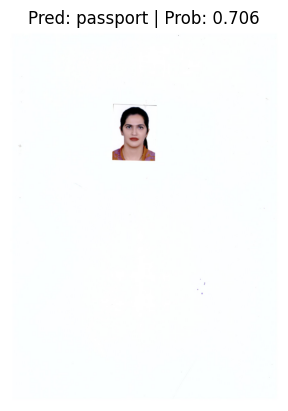

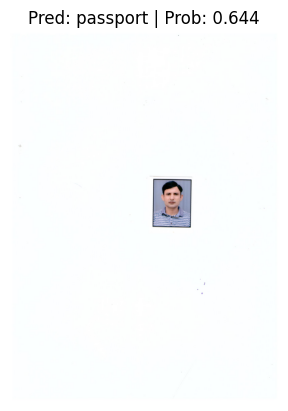

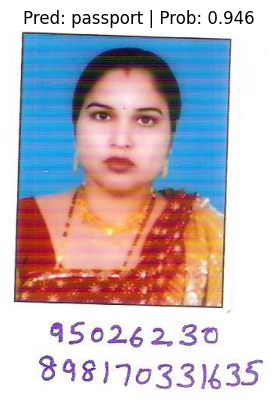

In [38]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpeg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

## Making inference on passport like Images

In [ ]:

# https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-1.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-2.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-3.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-4.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-5.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-6.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-7.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-8.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-9.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-10.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-11.jpg


In [41]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "passport-1.jpg"
custom_image_path_1 = data_path / "passport-2.jpg"
# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-1.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

if not custom_image_path_1.is_file():
    with open(custom_image_path_1, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/nitintimble/human_passport/blob/main/inference/passport/passport-1.jpg")
        print(f"Downloading {custom_image_path_1}...")
        f.write(request.content)
else:
    print(f"{custom_image_path_1} already exists, skipping download.")

In [44]:
custom_image_path, custom_image_path_1

(PosixPath('data/passport-1.jpg'), PosixPath('data/passport-2.jpg'))

In [43]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

UnidentifiedImageError: cannot identify image file '/content/data/passport-1.jpg'

In [ ]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path_1,
                    class_names=class_names)

In [ ]:
# https://m.media-amazon.com/images/I/51hgeNPxHqL._SY879_.jpg
# https://m.media-amazon.com/images/I/816Mhp5nQIL._SY879_.jpg

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "amazon-women-long-sleeves.jpeg"
custom_image_path_1 = data_path / "amazon-women-long-sleeves_1.jpeg"
# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://m.media-amazon.com/images/I/51hgeNPxHqL._SY879_.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

if not custom_image_path_1.is_file():
    with open(custom_image_path_1, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://m.media-amazon.com/images/I/816Mhp5nQIL._SY879_.jpg")
        print(f"Downloading {custom_image_path_1}...")
        f.write(request.content)
else:
    print(f"{custom_image_path_1} already exists, skipping download.")

In [ ]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path_1,
                    class_names=class_names)

# Inference on non passport liek images


In [ ]:
# https://github.com/nitintimble/human_passport/blob/main/inference/nopassport/nopassport-1.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/nopassport/nopassport-2.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/nopassport/nopassport-3.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/nopassport/nopassport-4.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/nopassport/nopassport-5.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/nopassport/nopassport-6.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/nopassport/nopassport-7.jpg
# https://github.com/nitintimble/human_passport/blob/main/inference/nopassport/nopassport-8.jpg


In [50]:
model_name = 'passport_nopassport_classifier'
sample_size = 130 # no of images used for fine tuning
epochs = 5
save_filepath = f"01_{model_name}_{sample_size}_images_{epochs}_epochs.pth"
save_model(model=model, target_dir="models", model_name=save_filepath)

[INFO] Saving model to: models/01_passport_nopassport_classifier_130_images_5_epochs.pth
